In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
def pkl_process(data=None, file=None, mode="dump"):
    f_mode = "wb" if mode == "dump" else "rb"
    load_data = None
    
    with open(file, f_mode) as f:
        if mode == "dump":
            pickle.dump(data, f)
        else:
            load_data = pickle.load(f)
    
    return load_data

In [4]:
seed = 13

# load categorized data and split train, test

In [5]:
df = pd.read_csv("categorized_NAFLD.csv")
df = df.drop(columns=['Unnamed: 0'])
df.shape

(488, 32)

In [6]:
df.head()

,NGT_IFG_,NGT__PRE,DM_STATU,MS,AGE,GNDR,ETHNICIT,BMI,HOMA,SBP,...,AST_M0,ALT_M0,BILIRRUB,PLATELET,ALBUMIN,TSH,MEAN_FPG,NASH_OU2,FIBROSI2,NAFLD_OU
0,0,0,1,0,0,0,0,2,0,1,...,0,0,0,1,1,0,2,0,0,0
1,1,2,0,1,2,1,2,3,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,1,2,1,2,2,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,1,0,1,0,0,3,1,1,...,0,0,0,1,1,0,2,0,0,0
4,0,0,1,1,3,1,0,2,1,1,...,0,0,0,1,1,0,2,0,0,0


In [93]:
# split the data fram to train and test and shuffle
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
print("train, test shape: ", train_df.shape, test_df.shape)

print("NAFLD counts in train test: ", len(train_df[train_df['NAFLD_OU'] == 1]), len(train_df[train_df['NAFLD_OU'] == 0]), 
      len(test_df[test_df['NAFLD_OU'] == 1]), len(test_df[test_df['NAFLD_OU'] == 0]))

print("fibrosis counts in train test: ", len(train_df[train_df['FIBROSI2'] == 1]), len(train_df[train_df['FIBROSI2'] == 0]), 
      len(test_df[test_df['FIBROSI2'] == 1]), len(test_df[test_df['FIBROSI2'] == 0]))

print("NASH_OU2 counts in train test: ", len(train_df[train_df['NASH_OU2'] == 1]), len(train_df[train_df['NASH_OU2'] == 0]), 
      len(test_df[test_df['NASH_OU2'] == 1]), len(test_df[test_df['NASH_OU2'] == 0]))

train, test shape:  (390, 32) (98, 32)
NAFLD counts in train test:  278 112 64 34
fibrosis counts in train test:  49 341 11 87
NASH_OU2 counts in train test:  163 227 35 63


In [8]:
train_df.head()

,NGT_IFG_,NGT__PRE,DM_STATU,MS,AGE,GNDR,ETHNICIT,BMI,HOMA,SBP,...,AST_M0,ALT_M0,BILIRRUB,PLATELET,ALBUMIN,TSH,MEAN_FPG,NASH_OU2,FIBROSI2,NAFLD_OU
268,0,0,1,1,2,1,0,2,0,1,...,0,0,1,1,1,0,1,1,0,1
444,0,0,1,1,1,1,2,3,1,1,...,0,0,1,1,1,0,2,1,0,1
118,3,1,0,0,2,0,3,1,2,0,...,0,0,0,0,1,1,0,0,0,0
449,0,0,1,1,2,1,3,3,1,1,...,1,1,0,1,1,0,2,0,0,1
207,0,0,1,1,1,0,3,3,2,0,...,1,1,0,1,0,0,0,0,0,1


In [9]:
#get training y label
train_y_nash, train_y_fib, train_y_nafld = np.array(train_df['NASH_OU2']), np.array(train_df['FIBROSI2']), np.array(train_df['NAFLD_OU'])
train_y_nafld[:5]

array([1, 1, 0, 1, 1])

In [10]:
train_X = train_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
train_X.shape, train_y_nafld.shape

((390, 29), (390,))

In [11]:
test_y_nash, test_y_fib, test_y_nafld = np.array(test_df['NASH_OU2']), np.array(test_df['FIBROSI2']), np.array(test_df['NAFLD_OU'])
test_X = test_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
test_X.shape, test_y_nafld.shape

((98, 29), (98,))

# data encoding

## one-hot encoding

In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, categories='auto')

In [24]:
ohe.fit(df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU']))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [25]:
train_X_ohe = ohe.transform(train_X)
test_X_ohe = ohe.transform(test_X)
train_X_ohe.shape, test_X_ohe.shape

((390, 73), (98, 73))

In [27]:
train_X_ohe[0], train_y_nafld[0], train_y_nash[0], train_y_fib[0]

(array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 0., 1., 0.]), 1, 1, 0)

## feature hashing

In [ ]:
from sklearn.feature_extraction import FeatureHasher
#convert data to uni-feature space then feature hashing (libsvm format first -> convert to dict)

# machine learning 

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def get_binary_cls_precision_recall_f1(true_labels, pred_probs, pos_idx, threshold=0.5):
    pred_lables = []
    for pred_prob in pred_probs:
        pos_prob = pred_prob[pos_idx]
        if pos_prob >= threshold:
            pred_lables.append(1)
        else:
            pred_lables.append(0)
    return precision_recall_fscore_support(true_labels, pred_lables, average='binary'), pred_lables

In [30]:
def get_full_cv_scores(model, train_X, train_y, test_X, test_y):
    l1=list(train_X)+list(test_X)
    l2=list(train_y)+list(test_y)

    l = list(zip(l1, l2))
    np.random.seed(seed)
    np.random.shuffle(l, )

    X = list(map(lambda x: x[0], l))
    y = list(map(lambda x: x[1], l))

    cv_res = cross_val_score(model, X, y, cv=5, n_jobs=1, scoring="roc_auc")
    return cv_res, np.average(cv_res)

In [31]:
def make_confusion_matrix(tl, pl):
    mat = confusion_matrix(tl, pl)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [32]:
def auc_roc_expr(classifer, tuned_parameters, train_X, train_y, test_X, test_y):
    gs = GridSearchCV(classifer, tuned_parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1) #scoring='roc_auc'
    gs.fit(train_X, train_y)
    print(gs.best_params_)
    print(gs.best_estimator_)
    clf = gs.best_estimator_
    clf.fit(train_X, train_y)
    pred_result = clf.predict_proba(test_X)
    idx = list(filter(lambda x: x==1, clf.classes_))[0]
    pred_result_1 = list(map(lambda x: x[idx], pred_result))
    fpr, tpr, thresholds = roc_curve(test_y, pred_result_1)
    plt.plot(fpr, tpr, lw=1, alpha=0.5)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    cut_off = get_cutoff(fpr, tpr, thresholds)
    print("AUC_ROC_score: ", roc_auc_score(test_y, pred_result_1), " cutoff: ", cut_off)
    return clf, fpr, tpr, thresholds, pred_result, cut_off

In [33]:
def get_cutoff(fpr, tpr, thresholds):
    opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    return thresholds[opt_idx]

## Logistic Regression

###  OHE as features

#### NAFLD

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s


{'C': 0.1, 'class_weight': None, 'max_iter': 50, 'random_state': 13, 'solver': 'liblinear', 'tol': 1e-05}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=1e-05, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   12.0s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


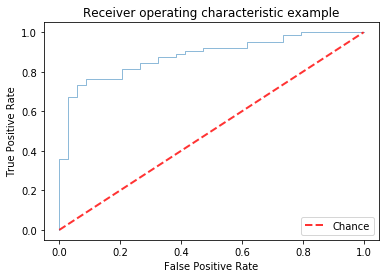

AUC_ROC_score:  0.8818933823529412  cutoff:  0.732519044922886


In [95]:
# AUC_ROC
tuned_parameters = {'max_iter':[50, 100, 500], 'tol':[0.00001, 0.0001, 0.001, 0.01],'random_state':[seed], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
                    'solver':['lbfgs', 'liblinear', 'newton-cg'], 'class_weight': [None, 'balanced']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(LogisticRegression(), tuned_parameters, 
                                                               train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)

In [96]:
'''
random_state in train_test_split
random_state=43, AUC_ROC_score:  0.9181372549019607  cutoff:  0.589327937535999
random_state=13, AUC_ROC_score:  0.8818933823529411  cutoff:  0.7325190449228863
random_state=23, AUC_ROC_score:  0.8180821917808219  cutoff:  0.6482708195516653
random_state=37, AUC_ROC_score:  0.7571014492753624  cutoff:  0.6753595392344012
'''

'\nrandom_state in train_test_split\nrandom_state=43, AUC_ROC_score:  0.9181372549019607  cutoff:  0.589327937535999\nrandom_state=13, AUC_ROC_score:  0.8818933823529411  cutoff:  0.7325190449228863\nrandom_state=23, AUC_ROC_score:  0.8180821917808219  cutoff:  0.6482708195516653\nrandom_state=37, AUC_ROC_score:  0.7571014492753624  cutoff:  0.6753595392344012\n'

In [97]:
# CV on train + test
get_full_cv_scores(clf, train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)

(array([0.86183575, 0.88105947, 0.8351927 , 0.85141988, 0.84381339]),
 0.8546642365091964)

In [98]:
#precision, recall, f1-score based on cut-off decided from ROC_AUC
get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.9423076923076923, 0.765625, 0.8448275862068965)

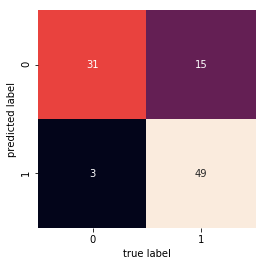

In [99]:
preds = get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nafld, preds)

#### nash

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    1.1s


{'C': 0.01, 'class_weight': None, 'max_iter': 50, 'random_state': 13, 'solver': 'liblinear', 'tol': 0.01}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.01, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   10.3s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


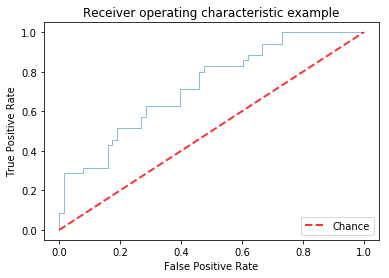

AUC_ROC_score:  0.7269841269841271  cutoff:  0.4184381836616085


In [100]:
tuned_parameters = {'max_iter':[50, 100, 500], 'tol':[0.00001, 0.0001, 0.001, 0.01],'random_state':[seed], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
                    'solver':['lbfgs', 'liblinear', 'newton-cg'], 'class_weight': [None, 'balanced']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(LogisticRegression(), tuned_parameters, 
                                                               train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)

In [101]:
get_full_cv_scores(clf, train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)

(array([0.77112069, 0.81508621, 0.80775862, 0.84217507, 0.73386384]),
 0.794000884173298)

In [85]:
p,r,f=get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
"pre:{}, rec:{}, f1:{}".format(p, r, f)

'pre:0.5333333333333333, rec:0.45714285714285713, f1:0.4923076923076923'

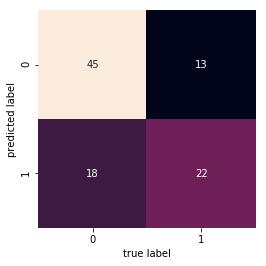

In [41]:
preds = get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nash, preds)

#### fabrosis

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    0.9s


{'C': 0.01, 'class_weight': None, 'max_iter': 50, 'random_state': 13, 'solver': 'lbfgs', 'tol': 1e-05}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='lbfgs',
          tol=1e-05, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   11.8s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


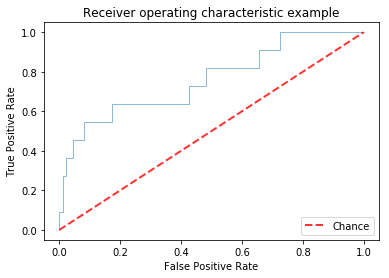

AUC_ROC_score:  0.760710553814002  cutoff:  0.13436848242339858


In [107]:
tuned_parameters = {'max_iter':[50, 100, 500], 'tol':[0.00001, 0.0001, 0.001, 0.01],'random_state':[seed], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
                    'solver':['lbfgs', 'liblinear', 'newton-cg'], 'class_weight': [None,'balanced']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(LogisticRegression(), tuned_parameters, 
                                                               train_X_ohe, train_y_fib, test_X_ohe, test_y_fib)

In [108]:
(get_full_cv_scores(clf, train_X_ohe, train_y_fib, test_X_ohe, test_y_fib))

(array([0.87693798, 0.8120155 , 0.86143411, 0.69411765, 0.71960784]),
 0.7928226174190607)

In [109]:
get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.3181818181818182, 0.6363636363636364, 0.4242424242424242)

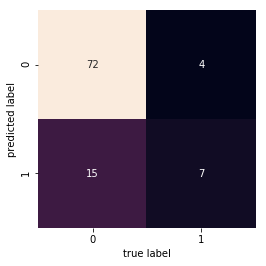

In [110]:
preds = get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_fib, preds)

### feature hashing as features

## Random Forest

In [31]:
# TODO visulization trees
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

### OHE

#### nafld

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=5, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=13,
            verbose=0, warm_start=False)


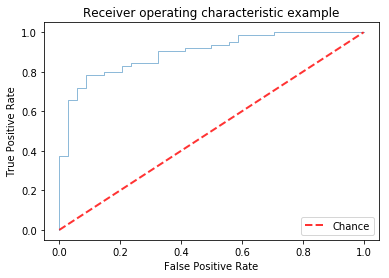

AUC_ROC_score:  0.8975183823529412  cutoff:  0.5375219365999689


In [111]:
# AUC_ROC
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)

In [112]:
# CV on train + test
get_full_cv_scores(clf, train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)

(array([0.85797101, 0.88855572, 0.85395538, 0.86663286, 0.84482759]),
 0.8623885116265397)

In [113]:
#precision, recall, f1-score based on cut-off decided from ROC_AUC
get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.9433962264150944, 0.78125, 0.8547008547008547)

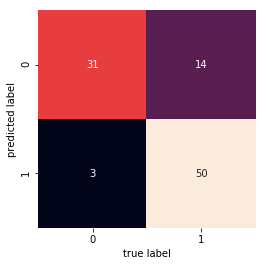

In [114]:
preds = get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nafld, preds)

#### fibrosis

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 567 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1167 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2167 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2817 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3567 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4417 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5367 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 6417 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7567 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 8817 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 10167 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 11617 tasks     

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=25, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=13,
            verbose=0, warm_start=False)


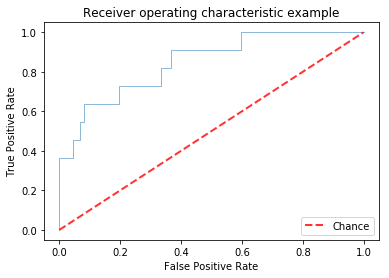

AUC_ROC_score:  0.8463949843260188  cutoff:  0.14782840794151167
5-fold CV: [0.875      0.89341085 0.88856589 0.63137255 0.79411765]; averaged: 0.8164933880528956
precision: 0.32; recall: 0.7272727272727273; f1-score: 0.4444444444444444


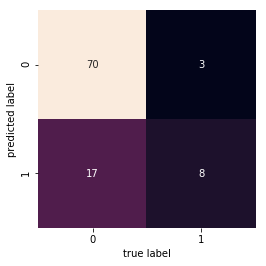

In [115]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X_ohe, train_y_fib, test_X_ohe, test_y_fib)
a, b = get_full_cv_scores(clf, train_X_ohe, train_y_fib, test_X_ohe, test_y_fib)
print("5-fold CV: {}; averaged: {}".format(a, b))
p,r,f = get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
print("precision: {}; recall: {}; f1-score: {}".format(p,r,f))
preds = get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_fib, preds)

#### nash

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1143 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2143 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2793 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3543 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4393 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 5343 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 6393 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 7543 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 8793 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 10143 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 11593 tasks     

{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)


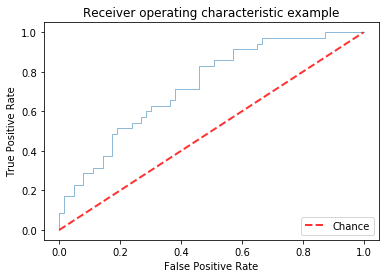

AUC_ROC_score:  0.7287981859410431  cutoff:  0.3167912579215618
5-fold CV: [0.78232759 0.82112069 0.78706897 0.8178603  0.74270557]; averaged: 0.7902166224580018
precision: 0.5102040816326531; recall: 0.7142857142857143; f1-score: 0.5952380952380952


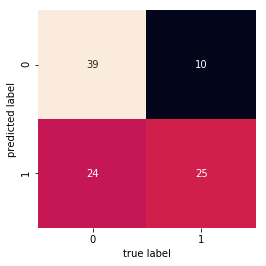

In [116]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)
a, b = get_full_cv_scores(clf, train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)
print("5-fold CV: {}; averaged: {}".format(a, b))
p,r,f = get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
print("precision: {}; recall: {}; f1-score: {}".format(p,r,f))
preds = get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nash, preds)

### no data transformation 

In [117]:
def fc(s):
    return {each:i for i, each in enumerate(s)}

def xys(l):
    return list(zip(*l))

In [118]:
df_svm = pd.read_csv("imputed_nafld.csv")
d = {0: fc(set(df_svm['NGT_IFG_'])), 1: fc(set(df_svm['NGT__PRE'])), 6: fc(set(df_svm['ETHNICIT']))}
nd = {0: len(set(df_svm['NGT_IFG_'])), 1: len(set(df_svm['NGT__PRE'])), 6: len(set(df_svm['ETHNICIT']))}


n_data = []
for each in df_svm.values:
    n_point = []
    for idx, v in enumerate(each):
        if idx in d:
            cat = list(np.zeros(shape=nd[idx]))
            cat[d[idx][v]] = 1
            n_point.extend(cat)
        
        else:
            n_point.append(v)
    n_data.append(n_point)

n_data_X = list(map(lambda x: x[:-3], n_data))

In [147]:
n_data_y_fib = list(map(lambda x: x[-2], n_data))
n_data_y_nash = list(map(lambda x: x[-3], n_data))
n_data_y_nalfd = list(map(lambda x: x[-1], n_data))

In [148]:
n_data_X = np.array(n_data_X)
data_nafld = list(zip(n_data_X, n_data_y_nalfd))
data_nash = list(zip(n_data_X, n_data_y_nash))
data_fib = list(zip(n_data_X, n_data_y_fib))

In [149]:
trs_nalfd, tss_nalfd = train_test_split(data_nafld, test_size=0.2, random_state=seed)
trs_nash, tss_nash = train_test_split(data_nash, test_size=0.2, random_state=seed)
trs_fib, tss_fib = train_test_split(data_fib, test_size=0.2, random_state=seed)

In [158]:
from collections import Counter
print(Counter(map(lambda x: x[1], trs_fib)), Counter(map(lambda x: x[1], trs_nash)), Counter(map(lambda x: x[1], trs_nalfd)))
print(Counter(map(lambda x: x[1], tss_fib)), Counter(map(lambda x: x[1], tss_nash)), Counter(map(lambda x: x[1], tss_nalfd)))

Counter({0: 341, 1: 49}) Counter({0: 227, 1: 163}) Counter({1: 278, 0: 112})
Counter({0: 87, 1: 11}) Counter({0: 63, 1: 35}) Counter({1: 64, 0: 34})


#### nafld

In [122]:
train_X, train_y = xys(trs_nalfd)
test_X, test_y = xys(tss_nalfd)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1962 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3362 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4212 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 5162 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 6212 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 7362 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 8612 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 9962 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 11412 tasks      |

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)


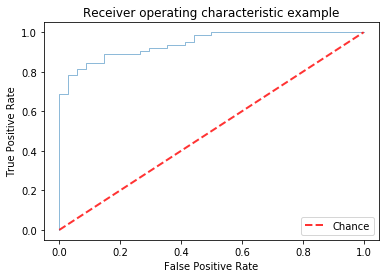

AUC_ROC_score:  0.9434742647058824  cutoff:  0.5371825426132374


In [123]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}

clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X, train_y, test_X, test_y)

In [124]:
get_full_cv_scores(clf, train_X, train_y, test_X, test_y)

(array([0.89275362, 0.90704648, 0.94472617, 0.913286  , 0.84381339]),
 0.9003251315518712)

In [125]:
get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.9473684210526315, 0.84375, 0.8925619834710744)

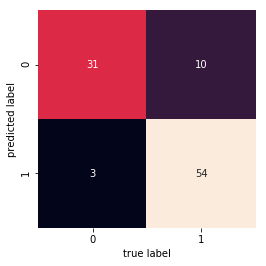

In [126]:
preds = get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nafld, preds)

#### fibrosis

In [162]:
train_X, train_y = xys(trs_fib)
test_X, test_y = xys(tss_fib)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)


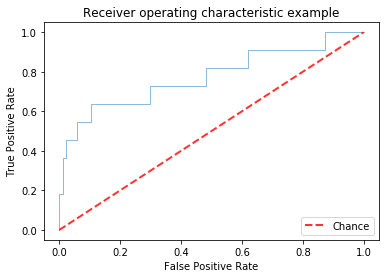

AUC_ROC_score:  0.774294670846395  cutoff:  0.1300059319525978


In [166]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [2, 5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}

clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X, train_y, test_X, test_y)

In [167]:
get_full_cv_scores(clf, train_X, train_y, test_X, test_y)

(array([0.82267442, 0.9370155 , 0.95445736, 0.77941176, 0.80196078]),
 0.8591039671682626)

In [168]:
get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.4375, 0.6363636363636364, 0.5185185185185185)

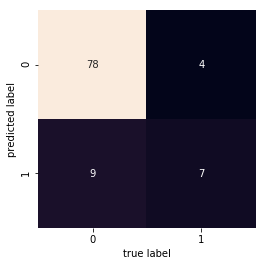

In [169]:
preds = get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y, preds)

#### nash

In [142]:
train_X, train_y = xys(trs_nash)
test_X, test_y = xys(tss_nash)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1962 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3362 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4212 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5162 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 6212 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 7362 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 8612 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 9962 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 11412 tasks      |

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 13}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)


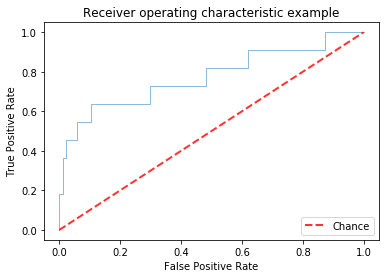

AUC_ROC_score:  0.774294670846395  cutoff:  0.1300059319525978


In [143]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(RandomForestClassifier(), tuned_parameters,
                                                              train_X, train_y, test_X, test_y)

In [144]:
get_full_cv_scores(clf, train_X, train_y, test_X, test_y)

(array([0.82267442, 0.9370155 , 0.95445736, 0.77941176, 0.80196078]),
 0.8591039671682626)

In [145]:
get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]

(0.4375, 0.6363636363636364, 0.5185185185185185)

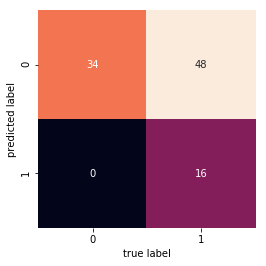

In [146]:
preds = get_binary_cls_precision_recall_f1(test_y, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nafld, preds)

## SVM

### OHE

In [175]:
tuned_parameters = {"C": [0.01, 0.1, 2, 64, 128, 512, 1024, 2048], 'probability':[True], 'tol': [0.1, 0.01, 0.001, 0.0001], 
                    'random_state':[seed], 'gamma': ['scale', 'auto']}

#### nafld

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    2.9s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 2, 'gamma': 'auto', 'probability': True, 'random_state': 13, 'tol': 0.01}
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.01,
  verbose=False)


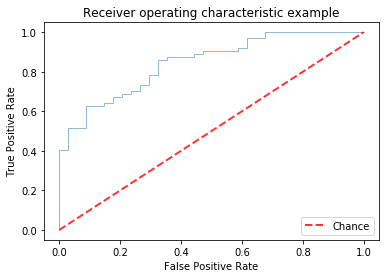

AUC_ROC_score:  0.8460477941176471  cutoff:  0.655402103912723
5-fold CV: [0.87342995 0.87206397 0.80172414 0.84432049 0.84533469]; averaged: 0.8473746460103282
precision: 0.8333333333333334; recall: 0.859375; f1-score: 0.8461538461538461


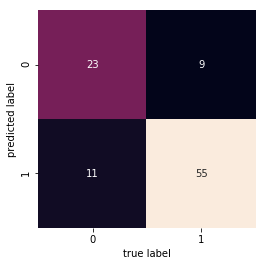

In [176]:
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(SVC(), tuned_parameters,
                                                              train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)
a, b = get_full_cv_scores(clf, train_X_ohe, train_y_nafld, test_X_ohe, test_y_nafld)
print("5-fold CV: {}; averaged: {}".format(a, b))
p,r,f = get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
print("precision: {}; recall: {}; f1-score: {}".format(p,r,f))
preds = get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nafld, preds)

#### nash

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    3.9s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.01, 'gamma': 'scale', 'probability': True, 'random_state': 13, 'tol': 0.01}
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.01,
  verbose=False)


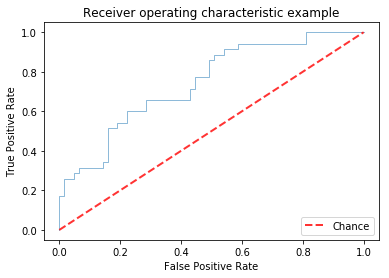

AUC_ROC_score:  0.7446712018140589  cutoff:  0.4199140514752229
5-fold CV: [0.78491379 0.84008621 0.81594828 0.83465959 0.73563218]; averaged: 0.8022480106100796
precision: 0.5609756097560976; recall: 0.6571428571428571; f1-score: 0.605263157894737


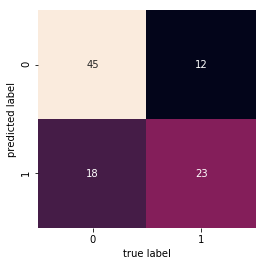

In [177]:
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(SVC(), tuned_parameters,
                                                              train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)
a, b = get_full_cv_scores(clf, train_X_ohe, train_y_nash, test_X_ohe, test_y_nash)
print("5-fold CV: {}; averaged: {}".format(a, b))
p,r,f = get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
print("precision: {}; recall: {}; f1-score: {}".format(p,r,f))
preds = get_binary_cls_precision_recall_f1(test_y_nash, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_nash, preds)

#### fibrosis

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    2.0s finished
/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 2, 'gamma': 'scale', 'probability': True, 'random_state': 13, 'tol': 0.01}
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.01,
  verbose=False)


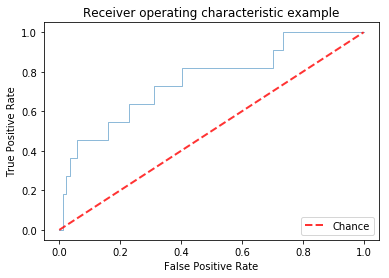

AUC_ROC_score:  0.7565308254963428  cutoff:  0.0947146516526663
5-fold CV: [0.77810078 0.82364341 0.88275194 0.62254902 0.69803922]; averaged: 0.761016871865025
precision: 0.22857142857142856; recall: 0.7272727272727273; f1-score: 0.34782608695652173


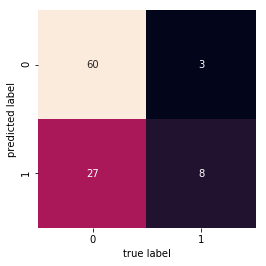

In [178]:
clf, fpr, tpr, thresholds, pred_result, cut_off = auc_roc_expr(SVC(), tuned_parameters,
                                                              train_X_ohe, train_y_fib, test_X_ohe, test_y_fib)
a, b = get_full_cv_scores(clf, train_X_ohe, train_y_fib, test_X_ohe, test_y_fib)
print("5-fold CV: {}; averaged: {}".format(a, b))
p,r,f = get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[0][:-1]
print("precision: {}; recall: {}; f1-score: {}".format(p,r,f))
preds = get_binary_cls_precision_recall_f1(test_y_fib, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)[1]
make_confusion_matrix(test_y_fib, preds)

## XGBoost

### no data transformation

#### nafld

#### nash

#### fibrosis

# feature elimination

- model:
- cv: 5-fold
- method: backward